# NLP

## 1. Установка и импорт необходимых библиотек

In [12]:
%pip install pandas numpy scikit-learn matplotlib wordcloud joblib seaborn ipython

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import joblib

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Загрузка и предварительный анализ данных

In [14]:
labeled_data_path = r"C:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 4\размеченный_разметка комментариев 2.csv"
try:
    df_labeled = pd.read_csv(labeled_data_path)
    print("Данные успешно загружены.")
    print(f"Количество строк: {len(df_labeled)}")
    print(f"Колонки: {df_labeled.columns.tolist()}")
    from IPython.display import display
    display(df_labeled.head())
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути {labeled_data_path}.")
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")

Данные успешно загружены.
Количество строк: 2373
Колонки: ['id', 'rating', 'comment', 'Нравится скорость отработки заявок', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Понравилось выполнение заявки', 'Вопрос решен', 'Без категории']


,id,rating,comment,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Вопрос решен,Без категории
0,2945792,5,спасибо,0,1,0,1,0,0
1,3234340,5,спасибо!,0,1,0,1,0,0
2,3380332,5,Отлично,0,1,0,1,0,0
3,3381812,5,Благодарю за оперативное решение проблемы !,1,1,0,1,1,0
4,3461991,5,Прекрасный специалист! Побольше таких,0,0,1,0,0,0


## 3. Подготовка данных для модели

In [15]:
target_categories = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен',
    'Без категории'
]
if 'df_labeled' in locals():
    # Проверка наличия всех колонок, включая 'Без категории'
    if 'Без категории' not in df_labeled.columns:
        print("ПРЕДУПРЕЖДЕНИЕ: Колонка 'Без категории' отсутствует в CSV. Убедитесь, что она есть или создайте ее.")

    missing_cols = [col for col in target_categories if col not in df_labeled.columns]
    if missing_cols:
        print(f"ОШИБКА: Следующие целевые колонки отсутствуют в CSV: {missing_cols}. Убедитесь, что они есть в файле.")
    else:
        print("Все целевые колонки (включая 'Без категории') присутствуют в данных.")

    def preprocess_text(text):
        text = str(text).lower()
        text = re.sub(f'[{re.escape(string.punctuation)}«»„"…–—]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    if 'comment' in df_labeled.columns and not missing_cols: # Продолжаем, только если все колонки есть
        df_labeled['processed_comment'] = df_labeled['comment'].apply(preprocess_text)
        X = df_labeled['processed_comment']
        y = df_labeled[target_categories] # Используем обновленный список категорий

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if y.shape[0] > 1 and y.nunique().all() else None)
        print(f"Обучающая выборка: {X_train.shape[0]}, тестовая: {X_test.shape[0]}")

        tfidf_vectorizer = TfidfVectorizer(max_features=300, ngram_range=(1,1))
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
        X_test_tfidf = tfidf_vectorizer.transform(X_test)
        print("TF-IDF векторизация (max_features=300, unigrams only).")
    elif 'comment' not in df_labeled.columns:
        print("ОШИБКА: Колонка 'comment' не найдена.")
    elif missing_cols: # Если колонки все еще отсутствуют после возможного создания
        print(f"ОШИБКА: Не удалось продолжить из-за отсутствия целевых колонок: {missing_cols}")
else:
    print("ОШИБКА: DataFrame 'df_labeled' не загружен. Выполните ячейку загрузки данных.")

Все целевые колонки (включая 'Без категории') присутствуют в данных.
Обучающая выборка: 1898, тестовая: 475
TF-IDF векторизация (max_features=300, unigrams only).


## 4. Обучение модели 

In [16]:
if 'X_train_tfidf' in locals() and 'y_train' in locals():
    base_classifier = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', C=0.01)
    multilabel_model = MultiOutputClassifier(base_classifier)
    try:
        multilabel_model.fit(X_train_tfidf, y_train)
        print("Модель обучена (Logistic Regression).")
    except Exception as e:
        print(f"Ошибка при обучении: {e}")
else:
    print("ОШИБКА: Обучающие данные не готовы.")

Модель обучена (Logistic Regression).


## 5. Графики

#### ROC-AUC

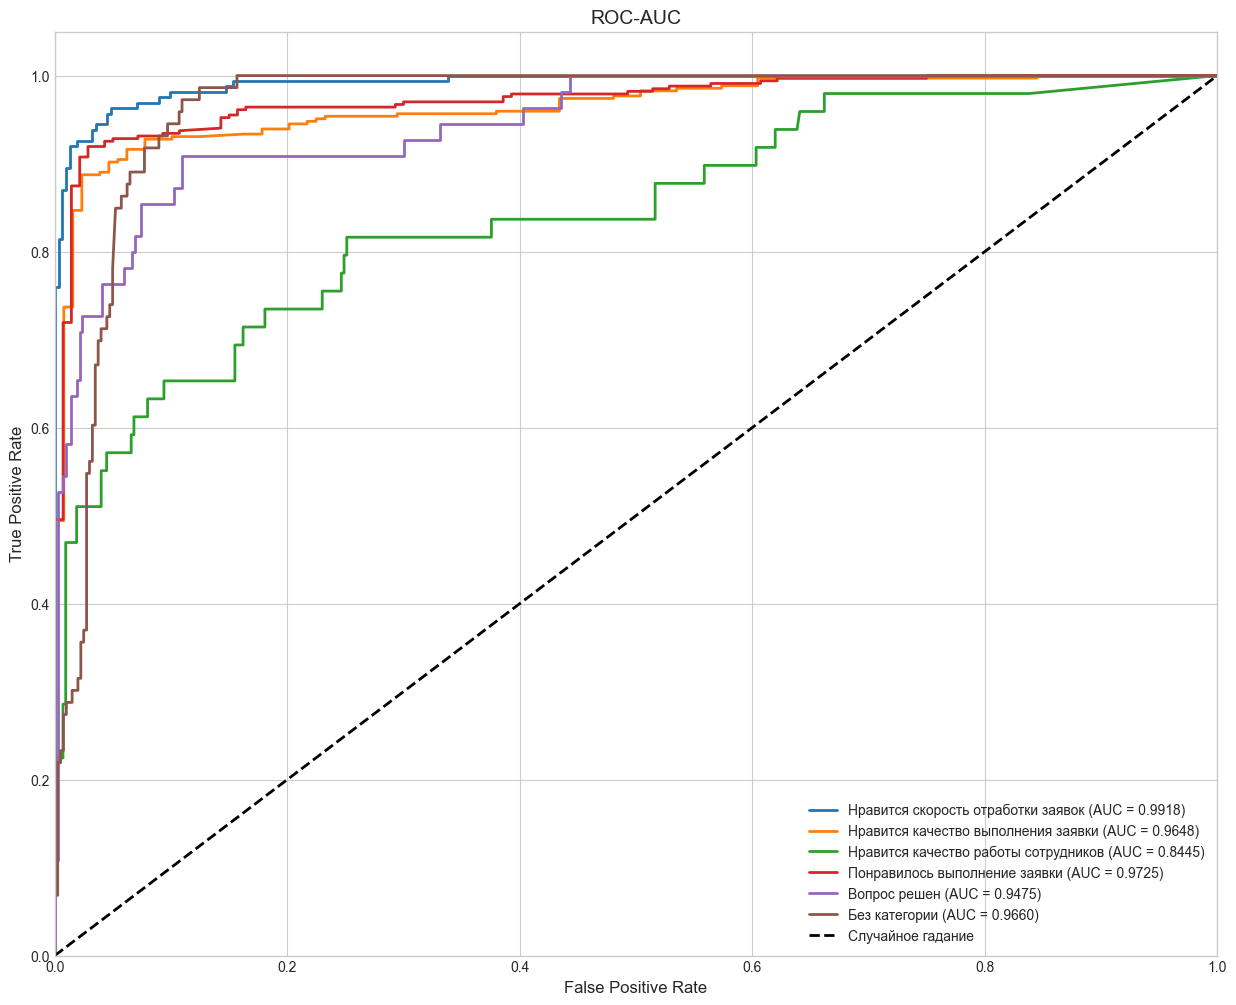

ROC-AUC scores:
Нравится скорость отработки заявок: 0.9918
Нравится качество выполнения заявки: 0.9648
Нравится качество работы сотрудников: 0.8445
Понравилось выполнение заявки: 0.9725
Вопрос решен: 0.9475
Без категории: 0.9660
Средний ROC-AUC (Macro): 0.9479


In [17]:
if 'multilabel_model' in locals() and 'X_test_tfidf' in locals() and 'y_test' in locals():
    roc_auc_scores = {}
    plt.figure(figsize=(15, 12))
    try:
        y_pred_proba_list = multilabel_model.predict_proba(X_test_tfidf)
        for i, category in enumerate(target_categories):
            y_pred_proba_category = y_pred_proba_list[i][:, 1]
            fpr, tpr, _ = roc_curve(y_test[category], y_pred_proba_category)
            roc_auc = auc(fpr, tpr)
            roc_auc_scores[category] = roc_auc
            plt.plot(fpr, tpr, lw=2, label=f'{category} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайное гадание')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC-AUC', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True)
        plt.show()
        print("ROC-AUC scores:")
        for category, score in roc_auc_scores.items():
            print(f"{category}: {score:.4f}")
        if roc_auc_scores:
            macro_roc_auc = np.mean(list(roc_auc_scores.values()))
            print(f"Средний ROC-AUC (Macro): {macro_roc_auc:.4f}")
    except Exception as e:
        print(f"Ошибка при оценке: {e}")
else:
    print("ОШИБКА: Модель или тестовые данные не готовы.")

#### Облако слов

Данные успешно загружены из C:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 4\размеченный_разметка комментариев 2.csv.
Количество строк: 2373
Колонка 'comment' успешно обработана и создана 'processed_comment'.
Генерация облака слов...


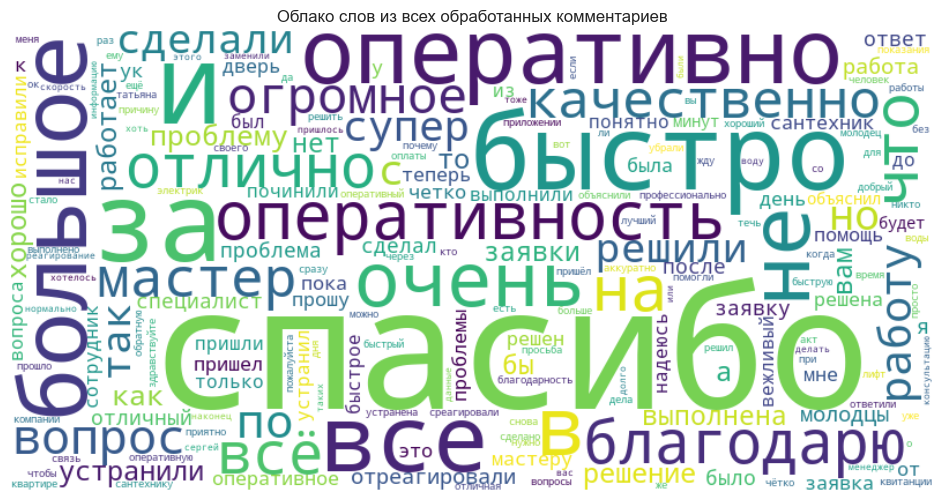

Облако слов успешно отображено.


In [18]:
import pandas as pd
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Путь к файлу CSV
labeled_data_path = r"C:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 4\размеченный_разметка комментариев 2.csv"

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(f'[{re.escape(string.punctuation)}«»„\"…–—]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

try:
    # 1. Загрузка данных
    df_labeled = pd.read_csv(labeled_data_path)
    print(f"Данные успешно загружены из {labeled_data_path}.")
    print(f"Количество строк: {len(df_labeled)}")

    # 2. Проверка наличия колонки 'comment' и ее предобработка
    if 'comment' in df_labeled.columns:
        df_labeled['processed_comment'] = df_labeled['comment'].apply(preprocess_text)
        print("Колонка 'comment' успешно обработана и создана 'processed_comment'.")
        
        # 3. Генерация облака слов
        all_comments_text = ' '.join(df_labeled['processed_comment'].dropna())
        
        if all_comments_text.strip(): # Проверяем, что есть текст для облака
            try:
                print("Генерация облака слов...")
                wordcloud = WordCloud(width=800, height=400, 
                                      background_color='white', 
                                      collocations=False, # Отключаем коллокации для более разнообразных слов
                                      # stopwords=['это', 'как', 'так', 'и', 'в', 'над', 'к', 'до', 'не', 'на', 'но', 'то']
                                     ).generate(all_comments_text)
                
                plt.figure(figsize=(12, 6))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title("Облако слов из всех обработанных комментариев")
                plt.show()
                print("Облако слов успешно отображено.")
            except ImportError:
                print("ОШИБКА: Библиотека wordcloud не установлена. Пожалуйста, установите ее: pip install wordcloud")
            except Exception as e_wc:
                print(f"Не удалось сгенерировать облако слов: {e_wc}")
        else:
            print("Нет данных для генерации облака слов (все комментарии пустые после обработки или отсутствуют).")
    else:
        print("ОШИБКА: Колонка 'comment' не найдена в CSV файле.")

except FileNotFoundError:
    print(f"ОШИБКА: Файл не найден по пути {labeled_data_path}. Проверьте правильность пути.")
except Exception as e_load:
    print(f"Произошла ошибка при загрузке или обработке данных: {e_load}")



## 6. Сохранение модели и векторизатора 

In [19]:
model_filename = 'nlp_model_final_v5_target.joblib'
vectorizer_filename = 'tfidf_vectorizer_final_v5_target.joblib'
if 'multilabel_model' in locals() and 'tfidf_vectorizer' in locals():
    try:
        joblib.dump(multilabel_model, model_filename)
        joblib.dump(tfidf_vectorizer, vectorizer_filename)
        print(f"Модель сохранена в {model_filename}")
        print(f"Векторизатор сохранен в {vectorizer_filename}")
    except Exception as e:
        print(f"Ошибка при сохранении: {e}")
else:
    print("ОШИБКА: Модель или векторизатор не обучены.")

Модель сохранена в nlp_model_final_v5_target.joblib
Векторизатор сохранен в tfidf_vectorizer_final_v5_target.joblib


## 7. F-score

Данные успешно загружены. Количество строк: 2373
Все целевые колонки присутствуют в данных.
Обучающая выборка: 1898, тестовая: 475
Модели успешно загружены.

Метрики по каждой категории:
Нравится скорость отработки заявок:
  Precision: 0.8914
  Recall: 0.9630
  F1-score: 0.9258

Нравится качество выполнения заявки:
  Precision: 0.9922
  Recall: 0.7370
  F1-score: 0.8458

Нравится качество работы сотрудников:
  Precision: 0.3333
  Recall: 0.6531
  F1-score: 0.4414

Понравилось выполнение заявки:
  Precision: 0.9919
  Recall: 0.7313
  F1-score: 0.8419

Вопрос решен:
  Precision: 0.2833
  Recall: 0.9273
  F1-score: 0.4340

Без категории:
  Precision: 0.4771
  Recall: 1.0000
  F1-score: 0.6460

Средние метрики:
Micro-average: Precision=0.7329, Recall=0.7961, F1-score=0.7632
Macro-average: Precision=0.6616, Recall=0.8353, F1-score=0.6892
Weighted-average: Precision=0.8694, Recall=0.7961, F1-score=0.8013

Подробный отчет о классификации:
                                      precision    rec

c:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


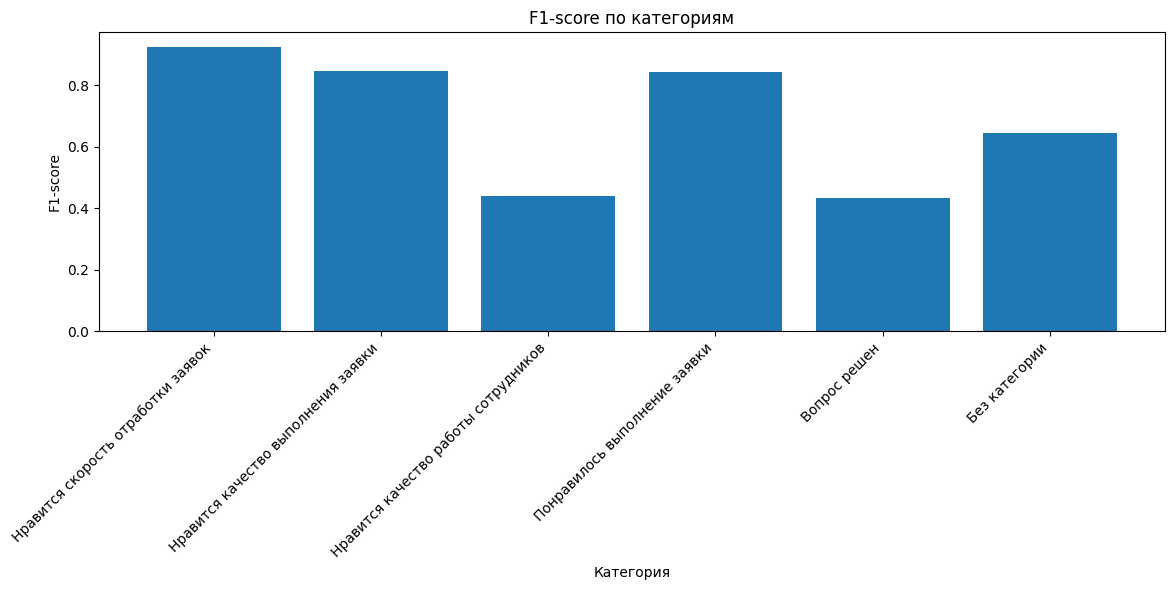

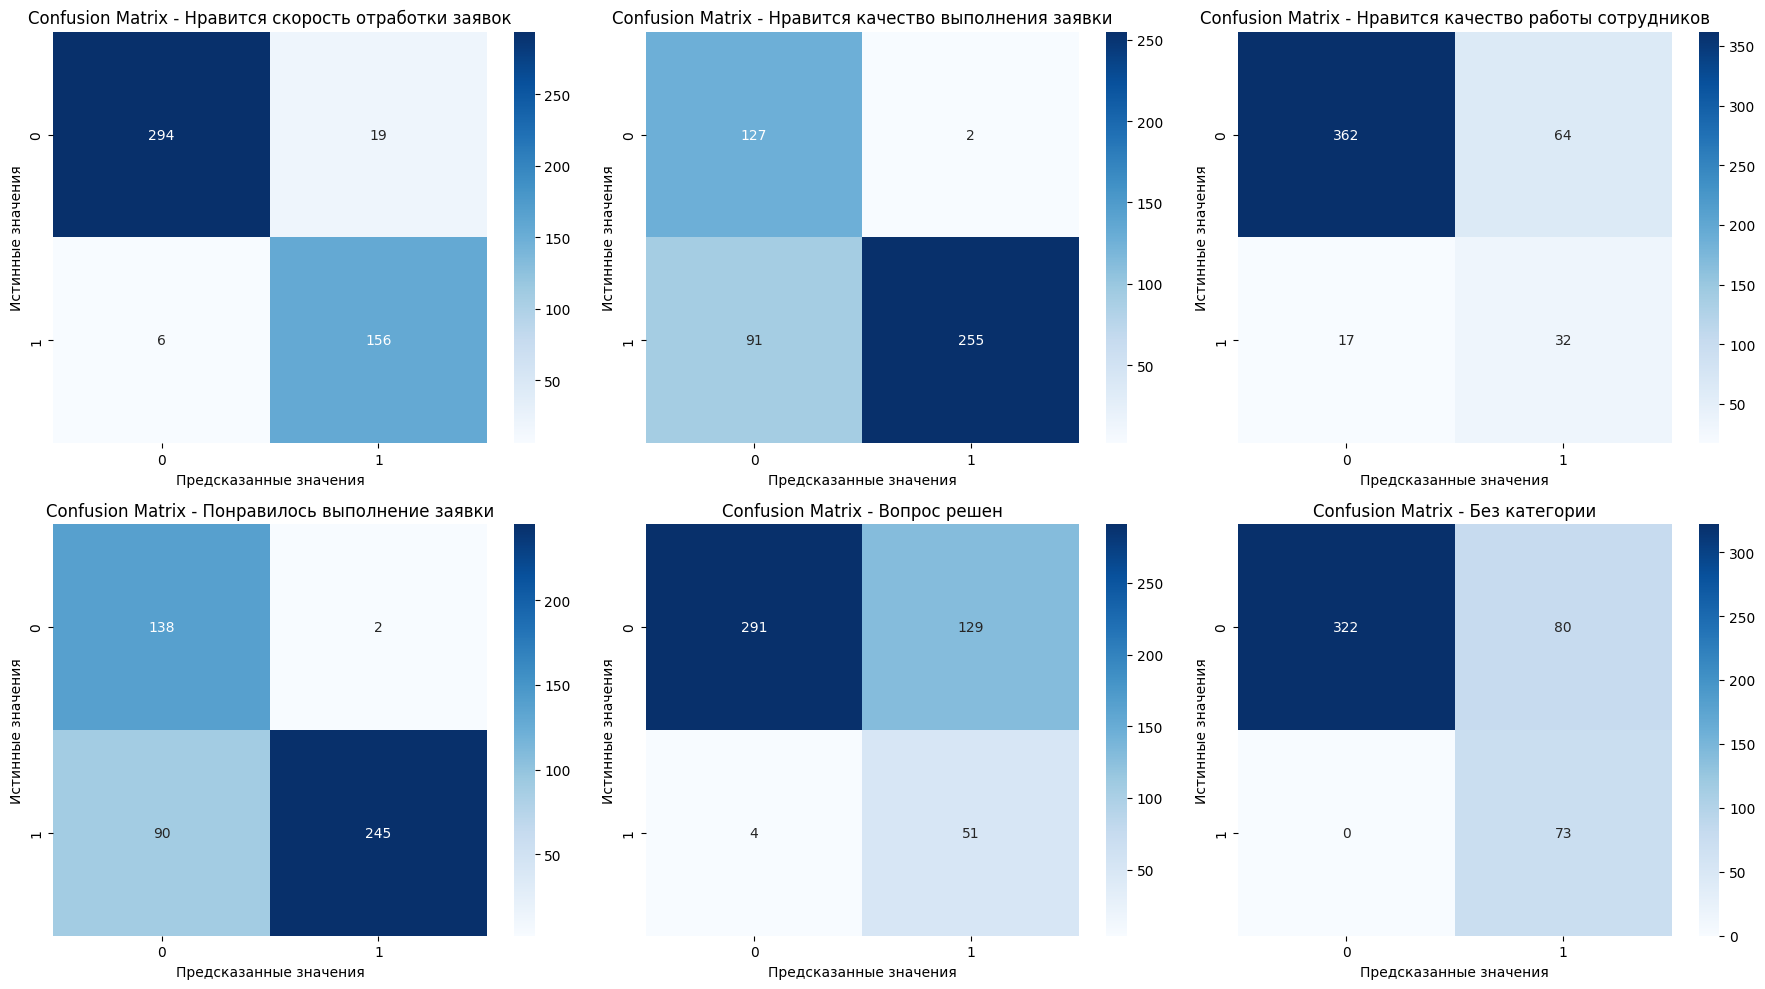


Анализ F-score завершен успешно!


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Предобработка текста
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(f'[{re.escape(string.punctuation)}«»„\"…–—]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 1. Загрузка данных
try:
    # Загрузка данный
    df_labeled = pd.read_csv('размеченный_разметка комментариев 2.csv')
except FileNotFoundError:
    # Если файл не найден
    csv_path = input("Введите путь к CSV файлу с размеченными комментариями: ")
    df_labeled = pd.read_csv(csv_path)

print(f"Данные успешно загружены. Количество строк: {len(df_labeled)}")

# 2. Определение целевых категорий
target_categories = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен',
    'Без категории'
]

# Проверка наличия всех колонок
missing_cols = [col for col in target_categories if col not in df_labeled.columns]
if missing_cols:
    raise ValueError(f"Следующие целевые колонки отсутствуют в CSV: {missing_cols}")
else:
    print("Все целевые колонки присутствуют в данных.")

# 3. Предобработка текста
df_labeled['processed_comment'] = df_labeled['comment'].apply(preprocess_text)

# 4. Подготовка данных для модели
X = df_labeled['processed_comment']
y = df_labeled[target_categories]

# 5. Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y if y.shape[0] > 1 and y.nunique().all() else None
)
print(f"Обучающая выборка: {X_train.shape[0]}, тестовая: {X_test.shape[0]}")

# 6. Загрузка сохраненных моделей
try:
    tfidf_vectorizer = joblib.load('tfidf_vectorizer_final_v5_target.joblib')
    model = joblib.load('nlp_model_final_v5_target.joblib')
    print("Модели успешно загружены.")
except FileNotFoundError:
    print("Файлы моделей не найдены в текущей директории.")
    vectorizer_path = input("Введите путь к файлу векторизатора (tfidf_vectorizer_final_v5_target.joblib): ")
    model_path = input("Введите путь к файлу модели (nlp_model_final_v5_target.joblib): ")
    tfidf_vectorizer = joblib.load(vectorizer_path)
    model = joblib.load(model_path)

# 7. Векторизация тестовых данных
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 8. Получение предсказаний модели
y_pred = model.predict(X_test_tfidf)

# 9. Расчет метрик для каждой категории
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

# 10. Расчет средних метрик
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# 11. Вывод результатов
print("\nМетрики по каждой категории:")
for i, category in enumerate(target_categories):
    print(f"{category}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1-score: {f1_per_class[i]:.4f}")
    print()

print("Средние метрики:")
print(f"Micro-average: Precision={precision_micro:.4f}, Recall={recall_micro:.4f}, F1-score={f1_micro:.4f}")
print(f"Macro-average: Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1-score={f1_macro:.4f}")
print(f"Weighted-average: Precision={precision_weighted:.4f}, Recall={recall_weighted:.4f}, F1-score={f1_weighted:.4f}")

# 12. Подробный отчет о классификации
print("\nПодробный отчет о классификации:")
report = classification_report(y_test, y_pred, target_names=target_categories)
print(report)

# 13. Визуализация F1-score для каждой категории
plt.figure(figsize=(12, 6))
plt.bar(target_categories, f1_per_class)
plt.title('F1-score по категориям')
plt.xlabel('Категория')
plt.ylabel('F1-score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 14. Визуализация confusion matrix для каждой категории
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Преобразуем DataFrame в numpy массивы для удобства индексации
y_test_np = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
y_pred_np = y_pred if isinstance(y_pred, np.ndarray) else np.array(y_pred)

for i, category in enumerate(target_categories):
    # Используем правильную индексацию для numpy массивов
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {category}')
    axes[i].set_xlabel('Предсказанные значения')
    axes[i].set_ylabel('Истинные значения')
    axes[i].set_xticklabels(['0', '1'])
    axes[i].set_yticklabels(['0', '1'])

plt.tight_layout()
plt.show()

print("\nАнализ F-score завершен успешно!")
